## StyleGAN2算法复现

StyleGAN2是来自NVIDIA LAB，它实力雄厚、财大气粗，一般公司和个人开发者完全比不了，因此研究成果价值较大。<br/>
本文复现StyleGAN2论文。


In [ ]:
@inproceedings{Karras2019stylegan2,
  title     = {Analyzing and Improving the Image Quality of {StyleGAN}},
  author    = {Tero Karras and Samuli Laine and Miika Aittala and Janne Hellsten and Jaakko Lehtinen and Timo Aila},
  booktitle = {Proc. CVPR},
  year      = {2020}
}

### 一、 前言
PaddleGAN用飞桨框架实现了StyleGAN2算法，但是基于StyleGAN2算法有不少优秀的衍生算法，PaddleGAN不可能一一实现。<br/>
为了方便StyleGAN2衍生算法复现，我从PaddleGAN中把StyleGAN2相关代码剥离了出来，并根据自身编程经验增强了可读性，十分适合初学者学习。

### 二、数据预处理
创建项目时引入AIStudio自带数据集FFHQ，分辨率256x256。

In [1]:
# 执行一遍就行
%cd /home/aistudio/data/data111879/
!tar -xvf images256x256.tar >/dev/null

/home/aistudio/data/data111879


### 三、StyleGAN2特性
#### 3.1 StyleGAN2自定义算子
请参考下列AIStudio的项目文件。<br/>
NVIDIA的大神用扎实的理论和大量实验，改良了之前算法常用的算子，功能仍然类似，具体如下：


* upfirdn2d.py 定义改进版的上采样层 + Blur（低通滤波消除混叠）
* fused_act.py 定义leakyReLU
* equalized.py 定义改进版的Linear层

***建议初学者把它们当成Library,不要阅读源码。<br/>***

#### 3.2 lazy regularization
StyleGAN每次计算loss都会做R1 Regularization。NVIDIA的大神发现没有必要，因此StyleGAN2改成了D网络每16次迭代做一次正则，G网络每4次迭代做一次正则。<br/>
理论来自论文《Which training methods for GANs do actually converge》

#### 3.3 为什么要Blur
引入Blur的原因来自论文《Making Convolutional Networks Shift-Invariant Again》<br/>
***建议初学者把这个当成结论，不要阅读论文。<br/>***

**引入依赖包**

In [1]:
import math
import random
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
import numpy as np

# 引入通用工具类
from equalized import EqualLinear
from fused_act import FusedLeakyReLU
from upfirdn2d import Upfirdn2dUpsample, Upfirdn2dBlur

### 四、StyleGAN2生成器

#### 4.1 引入g_utils工具类
g_utils是G网络专用工具类，作用请看代码中的注释。

In [2]:
from g_utils import PixelNorm, ConstantInput, StyledConv, ToRGB

#### 4.2 StyleGAN2的G网络

In [3]:
class Generator(nn.Layer):
    def __init__(self,
                 size,
                 style_dim,
                 n_mlp,
                 channel_multiplier=2,
                 blur_kernel=[1, 3, 3, 1],
                 lr_mlp=0.01,
                 is_concat=False):
        super().__init__()

        self.size = size

        self.style_dim = style_dim

        layers = [PixelNorm()]

        for i in range(n_mlp):
            layers.append(
                EqualLinear(style_dim,
                            style_dim,
                            lr_mul=lr_mlp,
                            activation="fused_lrelu"))

        self.style = nn.Sequential(*layers)

        self.channels = {
            4: 512,
            8: 512,
            16: 512,
            32: 512,
            64: 256 * channel_multiplier,
            128: 128 * channel_multiplier,
            256: 64 * channel_multiplier,
            512: 32 * channel_multiplier,
            1024: 16 * channel_multiplier,
        }

        self.input = ConstantInput(self.channels[4])
        self.conv1 = StyledConv(self.channels[4],
                                self.channels[4],
                                3,
                                style_dim,
                                blur_kernel=blur_kernel,
                                is_concat=is_concat)
        self.to_rgb1 = ToRGB(self.channels[4] *
                             2 if is_concat else self.channels[4],
                             style_dim,
                             upsample=False)

        self.log_size = int(math.log(size, 2))
        self.num_layers = (self.log_size - 2) * 2 + 1

        self.convs = nn.LayerList()
        self.upsamples = nn.LayerList()
        self.to_rgbs = nn.LayerList()
        self.noises = nn.Layer()

        in_channel = self.channels[4]

        for layer_idx in range(self.num_layers):
            res = (layer_idx + 5) // 2
            shape = [1, 1, 2**res, 2**res]
            self.noises.register_buffer(f"noise_{layer_idx}",
                                        paddle.randn(shape))

        for i in range(3, self.log_size + 1):
            out_channel = self.channels[2**i]

            self.convs.append(
                StyledConv(
                    in_channel * 2 if is_concat else in_channel,
                    out_channel,
                    3,
                    style_dim,
                    upsample=True,
                    blur_kernel=blur_kernel,
                    is_concat=is_concat,
                ))

            self.convs.append(
                StyledConv(out_channel * 2 if is_concat else out_channel,
                           out_channel,
                           3,
                           style_dim,
                           blur_kernel=blur_kernel,
                           is_concat=is_concat))

            self.to_rgbs.append(
                ToRGB(out_channel * 2 if is_concat else out_channel, style_dim))

            in_channel = out_channel

        self.n_latent = self.log_size * 2 - 2
        self.is_concat = is_concat

    def make_noise(self):
        noises = [paddle.randn((1, 1, 2**2, 2**2))]

        for i in range(3, self.log_size + 1):
            for _ in range(2):
                noises.append(paddle.randn((1, 1, 2**i, 2**i)))

        return noises

    def mean_latent(self, n_latent):
        latent_in = paddle.randn((n_latent, self.style_dim))
        latent = self.style(latent_in).mean(0, keepdim=True)

        return latent

    def get_latent(self, inputs):
        return self.style(inputs)

    def get_mean_style(self):
        mean_style = None
        with paddle.no_grad():
            for i in range(10):
                style = self.mean_latent(1024)
                if mean_style is None:
                    mean_style = style
                else:
                    mean_style += style

        mean_style /= 10
        return mean_style

    def forward(
        self,
        styles,
        return_latents=False,
        inject_index=None,
        truncation=1.0,
        truncation_latent=None,
        input_is_latent=False,
        noise=None,
        randomize_noise=True,
    ):
        if not input_is_latent:
            styles = [self.style(s) for s in styles]

        if noise is None:
            if randomize_noise:
                noise = [None] * self.num_layers
            else:
                noise = [
                    getattr(self.noises, f"noise_{i}")
                    for i in range(self.num_layers)
                ]

        if truncation < 1.0:
            style_t = []
            if truncation_latent is None:
                truncation_latent = self.get_mean_style()
            for style in styles:
                style_t.append(truncation_latent + truncation *
                               (style - truncation_latent))

            styles = style_t

        if len(styles) < 2:
            inject_index = self.n_latent

            if styles[0].ndim < 3:
                latent = styles[0].unsqueeze(1).tile((1, inject_index, 1))

            else:
                latent = styles[0]

        else:
            if inject_index is None:
                inject_index = random.randint(1, self.n_latent - 1)

            latent = styles[0].unsqueeze(1).tile((1, inject_index, 1))
            latent2 = styles[1].unsqueeze(1).tile(
                (1, self.n_latent - inject_index, 1))

            latent = paddle.concat([latent, latent2], 1)

        out = self.input(latent)
        out = self.conv1(out, latent[:, 0], noise=noise[0])

        skip = self.to_rgb1(out, latent[:, 1])

        i = 1
        if self.is_concat:
            noise_i = 1

            outs = []
            for conv1, conv2, to_rgb in zip(self.convs[::2], self.convs[1::2],
                                            self.to_rgbs):
                out = conv1(out, latent[:, i],
                            noise=noise[(noise_i + 1) // 2])  ### 1 for 2
                out = conv2(out,
                            latent[:, i + 1],
                            noise=noise[(noise_i + 2) // 2])  ### 1 for 2
                skip = to_rgb(out, latent[:, i + 2], skip)

                i += 2
                noise_i += 2
        else:
            for conv1, conv2, noise1, noise2, to_rgb in zip(
                    self.convs[::2], self.convs[1::2], noise[1::2], noise[2::2],
                    self.to_rgbs):
                out = conv1(out, latent[:, i], noise=noise1)
                out = conv2(out, latent[:, i + 1], noise=noise2)
                skip = to_rgb(out, latent[:, i + 2], skip)

                i += 2

        image = skip

        if return_latents:
            return image, latent

        else:
            return image, None

#### 4.3 预览G网络（可选）

In [ ]:
G = Generator(256, 512, 8)
print(G)

### 五、StyleGAN2判别器

#### 5.1 引入d_utils专用工具类
引入Discriminator网络的专用依赖。D网络本质是分类器。

In [4]:
from d_utils import ConvLayer, ResBlock

#### 5.2 StyleGAN2的D网络

In [5]:
class Discriminator(nn.Layer):

    def __init__(self, size, channel_multiplier=2, blur_kernel=[1, 3, 3, 1]):
        super().__init__()

        channels = {
            4: 512,
            8: 512,
            16: 512,
            32: 512,
            64: 256 * channel_multiplier,
            128: 128 * channel_multiplier,
            256: 64 * channel_multiplier,
            512: 32 * channel_multiplier,
            1024: 16 * channel_multiplier,
        }

        convs = [ConvLayer(3, channels[size], 1)]

        log_size = int(math.log(size, 2))

        in_channel = channels[size]

        for i in range(log_size, 2, -1):
            out_channel = channels[2**(i - 1)]

            convs.append(ResBlock(in_channel, out_channel, blur_kernel))

            in_channel = out_channel

        self.convs = nn.Sequential(*convs)

        self.stddev_group = 4
        self.stddev_feat = 1

        self.final_conv = ConvLayer(in_channel + 1, channels[4], 3)
        self.final_linear = nn.Sequential(
            EqualLinear(channels[4] * 4 * 4,
                        channels[4],
                        activation="fused_lrelu"),
            EqualLinear(channels[4], 1),
        )

    def forward(self, input):
        out = self.convs(input)

        batch, channel, height, width = out.shape
        group = min(batch, self.stddev_group)
        stddev = out.reshape((group, -1, self.stddev_feat,
                              channel // self.stddev_feat, height, width))
        stddev = paddle.sqrt(var(stddev, 0, unbiased=False) + 1e-8)
        stddev = stddev.mean([2, 3, 4], keepdim=True).squeeze(2)
        stddev = stddev.tile((group, 1, height, width))
        out = paddle.concat([out, stddev], 1)

        out = self.final_conv(out)

        out = out.reshape((batch, -1))
        out = self.final_linear(out)

        return out

# 这是飞桨框架的一个bug，据说要在v2.3中解决
# temporally solve pow double grad problem
def var(x, axis=None, unbiased=True, keepdim=False, name=None):

    u = paddle.mean(x, axis, True, name)
    out = paddle.sum((x - u) * (x - u), axis, keepdim=keepdim, name=name)

    n = paddle.cast(paddle.numel(x), x.dtype) \
        / paddle.cast(paddle.numel(out), x.dtype)
    if unbiased:
        one_const = paddle.ones([1], x.dtype)
        n = paddle.where(n > one_const, n - 1., one_const)
    out /= n
    return out

#### 5.3 预览D网络（可选）

In [ ]:
D = Discriminator(256)
print(D)

### 六、 StyleGAN2模型定义

In [ ]:
GAN系列算法至少有两个子网D、G。<br/>
为了便于理解，代码用StyleGanModel类把子网包起来，此书写方法适用所有GAN算法。<br/>
这样train的代码就很清晰。<br/>
StyleGAN2结合了一些最新的科研成果，因此比之前的GAN算法复杂，具体请看代码注释。<br/>

In [6]:
import random
import math
import paddle
import paddle.nn as nn
import paddle.optimizer as optim
import paddle.nn.functional as F

class StyleGanModel(nn.Layer):
    def __init__(self):
        super(StyleGanModel, self).__init__()
        # TODO 调参
        lr = 0.0002
        beta1=0.5
        beta2=0.999
        self.num_style_feat = 512
        self.r1_reg_weight = 10
        self.path_reg_weight = 2
        self.mean_path_length = 0
        self.netG = Generator(256, 512, 8)
        self.netD = Discriminator(256)
        self.g_optimizer = optim.Adam(parameters=self.netG.parameters(), learning_rate=lr, beta1=beta1, beta2=beta2)
        self.d_optimizer = optim.Adam(parameters=self.netD.parameters(), learning_rate=lr, beta1=beta1, beta2=beta2)

        # init EMA
        self.netG_ema = Generator(256, 512, 8)
        self.model_ema(0)

        # 计数器
        self.current_iter = 0

    def forward(self, real_img):
        '''
            请对照《CGAN算法复现》refined.ipynb
            https://aistudio.baidu.com/aistudio/projectdetail/4303742
            注意： StyleGAN2不需要输入labels
            注意： StyleGAN2的G、D网络都不需要输入condition
            注意： StyleGAN2的Constant input 移入Generator中了
            注意： D网络每16个迭代做一次正则（惩罚项目）
            注意： G网络每4个迭代做一次正则（惩罚项目）
        '''
        self.current_iter = self.current_iter + 1
        batch = real_img.shape[0]
        # define noise input
        noise = self.mixing_noise(batch, 0.9)

        # Change Guass input to Constant input, move into Generator
        # Generate fake_img
        fake, _ = self.netG(noise)
        # minimize D network by real_img + fake_img 
        self.d_optimizer.clear_grad()
        p_real=self.netD(real_img)
        p_fake=self.netD(fake.detach())
        d_loss = self.d_logistic_loss(p_real, p_fake)
        d_loss.backward()
        self.d_optimizer.step()
        # D network lazy regularization
        self.d_lazy_reg(real_img)

        # minimize G network
        self.g_optimizer.clear_grad()
        p_fake = self.netD(fake)
        g_loss = self.g_logistic_loss(p_fake)
        g_loss.backward()
        self.g_optimizer.step()
        # G network lazy regularization
        self.g_lazy_reg(noise)

        return d_loss,g_loss,fake  

    def make_noise(self, batch, num_noise):
        if num_noise == 1:
            noises = paddle.randn([batch, self.num_style_feat])
        else:
            noises = []
            for _ in range(num_noise):
                noises.append(paddle.randn([batch, self.num_style_feat]))
        return noises

    def mixing_noise(self, batch, prob):
        if random.random() < prob:
            return self.make_noise(batch, 2)
        else:
            return [self.make_noise(batch, 1)]

    def d_logistic_loss(self, p_real, p_fake):
        real_loss = F.softplus(-p_real)
        fake_loss = F.softplus(p_fake)

        return real_loss.mean() + fake_loss.mean()

    def g_logistic_loss(self, p_fake):
        return F.softplus(-p_fake).mean()

    def d_lazy_reg(self, real_img):
        if self.current_iter % 16 == 0:
            real_img.stop_gradient = False
            p_real=self.netD(real_img)
            d_r1_loss = self.r1_penalty(p_real, real_img)
            self.d_optimizer.clear_grad()
            (self.r1_reg_weight / 2 * d_r1_loss * 16 + 0 * p_real[0]).backward()
            self.d_optimizer.step()

    def g_lazy_reg(self, noise):
        if self.current_iter % 4 == 0:
            fake_img, latents = self.netG(noise, return_latents=True)
            l_g_path, path_lengths, self.mean_path_length = self.g_path_regularize(
                fake_img, latents, self.mean_path_length)

            self.g_optimizer.clear_grad()
            (self.path_reg_weight * 4 * l_g_path + 0 * fake_img[0, 0, 0, 0]).backward()
            self.g_optimizer.step()

    def r1_penalty(self, real_pred, real_img):
        '''
        StyleGAN论文中每个batch都有此惩罚项
        StyleGAN2论文中每16个batch一次（lazy regularzation章节）
        来自论文《Which training methods for GANs do actually converge》
        '''
        grad_real = paddle.grad(outputs=real_pred.sum(),
                                inputs=real_img,
                                create_graph=True)[0]
        grad_penalty = (grad_real * grad_real).reshape([grad_real.shape[0],
                                                        -1]).sum(1).mean()
        return grad_penalty

    def g_path_regularize(self, fake_img, latents, mean_path_length, decay=0.01):
        noise = paddle.randn(fake_img.shape) / math.sqrt(
            fake_img.shape[2] * fake_img.shape[3])
        grad = paddle.grad(outputs=(fake_img * noise).sum(),
                        inputs=latents,
                        create_graph=True)[0]
        path_lengths = paddle.sqrt((grad * grad).sum(2).mean(1))

        path_mean = mean_path_length + decay * (path_lengths.mean() -
                                                mean_path_length)

        path_penalty = ((path_lengths - path_mean) *
                        (path_lengths - path_mean)).mean()

        return path_penalty, path_lengths.detach().mean(), path_mean.detach()

    def model_ema(self, decay=0.999):
        '''
        EMA：跟股票中的移动平均线一样
        '''
        g_p = dict(self.netG.named_parameters())
        ema_g_p = dict(self.netG_ema.named_parameters())
        for k in ema_g_p.keys():
            ema_g_p[k].set_value(ema_g_p[k] * (decay) + (g_p[k] * (1 - decay)))

### 七、训练
#### 7.1训练数据集类定义

In [7]:
!pip install scikit-image

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


In [8]:
from ffhq_dataset import MyDataSet

batch=16
train_dataset = MyDataSet()
train_loader = paddle.io.DataLoader(train_dataset, batch_size=batch, shuffle=True,num_workers=2,drop_last=True)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


#### 预览训练数据函数

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
output_path='work'
def show_image_grid(fake, epoch_id):
    # 每轮的生成结果
    generated_image = fake.numpy()
    plt.figure(figsize=(26,26))
    try:
        for i in range(10):
            image = generated_image[i].transpose()
            image = np.clip(image, 0, 1)
            plt.subplot(10, 10, i + 1)
            plt.imshow(image.astype('uint8'), vmin=-1, vmax=1)
            plt.axis('off')
            plt.xticks([])
            plt.yticks([])
            plt.subplots_adjust(wspace=0.1, hspace=0.1)
        msg = 'Epoch ID={0} Batch ID={1} \n\n D-Loss={2} G-Loss={3}'.format(epoch_id, batch_id, d_loss.numpy()[0], g_loss.numpy()[0])
        plt.suptitle(msg,fontsize=20)
        plt.show()
        # plt.draw()
        # plt.savefig('{}/{:04d}_{:04d}.png'.format(output_path, epoch_id, batch_id),bbox_inches='tight')
        plt.close()
    except IOError:
        print(IOError)

#### 执行训练

W0915 21:46:07.736582 12656 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 11.2
W0915 21:46:07.741622 12656 gpu_resources.cc:91] device: 0, cuDNN Version: 8.2.


train...
epoch = 0 , d_loss = [0.05909483] , g_loss = [4.6601195]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:101: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  ret = np.asscalar(ex)


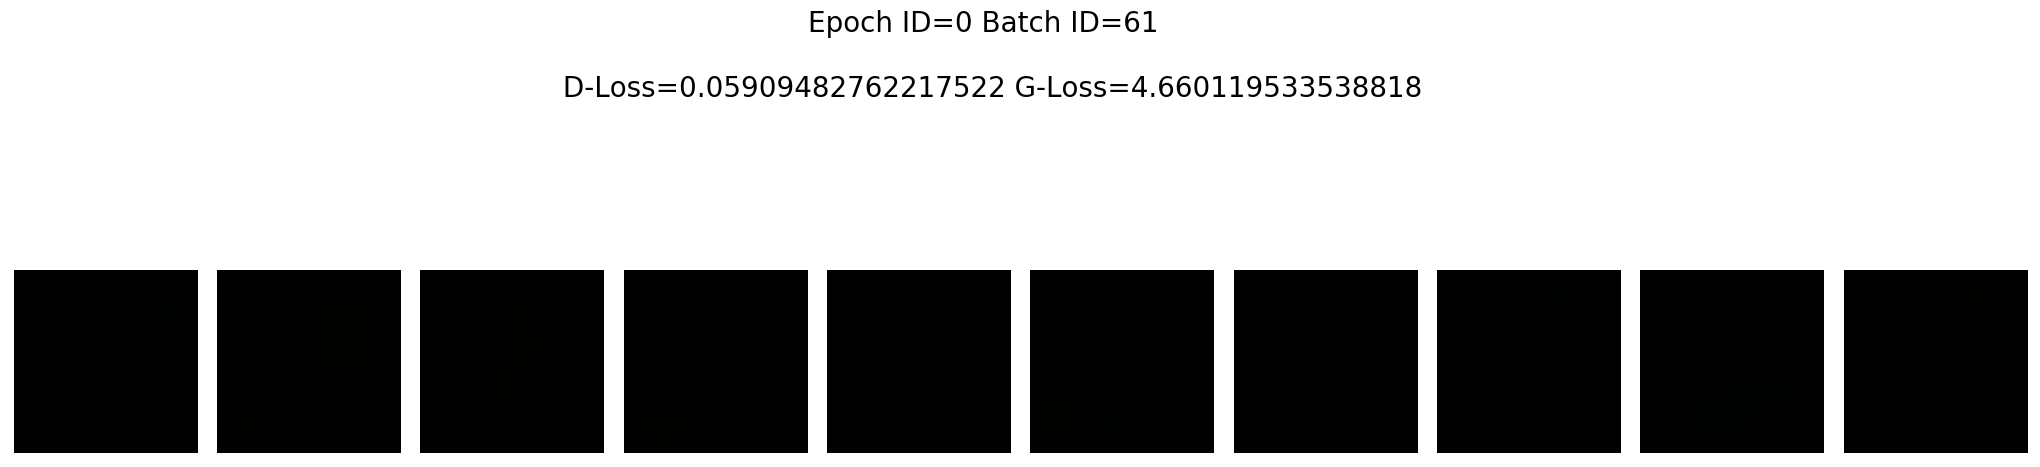

KeyboardInterrupt: 

In [11]:
epoches = 100

stylegan = StyleGanModel()
print('train...')
for epoch in range(epoches):
    for batch_id, data in enumerate(train_loader()):
        images = data[0]
        d_loss, g_loss, fake = stylegan(images)
    if epoch % 10 == 0 or epoch == (epoches - 1 ):
        print('epoch =', epoch, ', d_loss =', d_loss.numpy(), ', g_loss =', g_loss.numpy())
        show_image_grid(fake, epoch)